# LightGBM

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

## Dataset
Define training/testing set by subject

In [2]:
Dataset = pd.read_csv("final_dataset.csv", index_col=0)

train_test_limit = 40

X = Dataset.drop("Expression", axis = 1)
X[X<1e-2]=0
y = Dataset[["Subject number", "Expression"]]

X_train = X[X["Subject number"] < train_test_limit].drop("Subject number", axis = 1)
y_train = y[y["Subject number"] < train_test_limit]["Expression"]

X_test = X[X["Subject number"] >= train_test_limit].drop("Subject number", axis=1)
y_test = y[y["Subject number"] >= train_test_limit]["Expression"]

### Cross-evaluation algorithm

In [3]:
subjects = [x for x in range(53) if x != 7] # skip subject 7

def cross_val(model):
    scores = []
    for i in range(10):
        subject = random.choices(subjects, k=10)
        X_tr = X[~X["Subject number"].isin(subject)].drop("Subject number", axis=1)
        y_tr = y[~y["Subject number"].isin(subject)]["Expression"]
        X_te = X[X["Subject number"].isin(subject)].drop("Subject number", axis=1)
        y_te = y[y["Subject number"].isin(subject)]["Expression"]
        model.fit(X_tr, y_tr)
        scores.append(model.score(X_te, y_te))
    return np.array(scores)

## Hyperparameters tuning

### n_estimators

In [4]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000]

test_scores = []
training_scores = []

best_score = 0
best_n = 0
for estimator in n_estimators:
   lgbm = LGBMClassifier(n_estimators=estimator, n_jobs=-1)
   lgbm.fit(X_train, y_train)
   score = lgbm.score(X_test, y_test)
   test_scores.append(score)
   training_scores.append(lgbm.score(X_train, y_train))
   if score > best_score : 
      best_n = estimator
      best_score = score


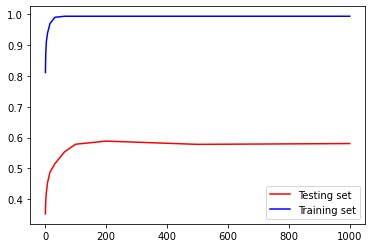

best n_estimator : 200


In [5]:
line1 = plt.plot(n_estimators, test_scores, 'r', label="Testing set")
line2 = plt.plot(n_estimators, training_scores, 'b', label="Training set")
plt.legend()
plt.show()
print("best n_estimator : " + str(best_n))

### Learning_rate

In [6]:
learning_rates = np.linspace(0.01, 1, 20, endpoint=True)
training_results = []
test_results = []
best_lr = 0
best_score = 0
for rate in learning_rates:
   lgbm = LGBMClassifier(learning_rate=rate, n_jobs=-1)
   lgbm.fit(X_train, y_train)
   training_results.append(lgbm.score(X_train, y_train))
   score = lgbm.score(X_test, y_test)
   test_results.append(score)
   if score > best_score : 
      best_lr = rate
      best_score = score

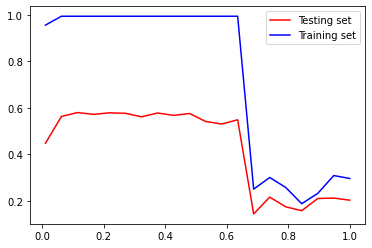

best learning rate : 0.11


In [7]:
line1 = plt.plot(learning_rates, test_results, 'r', label="Testing set")
line2 = plt.plot(learning_rates, training_results, 'b', label="Training set")
plt.legend()
plt.show()
print("best learning rate : %0.2f" % best_lr)

### num_leaves

In [8]:
num_leave = [2, 4, 8, 16, 32, 64, 100, 200]

test_scores = []
training_scores = []

best_score = 0
best_num = 0
for leave in num_leave:
   lgbm = LGBMClassifier(n_estimators=16, learning_rate=0.65, num_leaves=leave).fit(X_train, y_train)
   score = lgbm.score(X_test, y_test)
   test_scores.append(score)
   training_scores.append(lgbm.score(X_train, y_train))
   if score > best_score:
      best_score = score
      best_num = leave



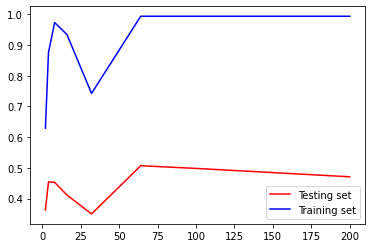

best num_leaves : 64


In [9]:
line1 = plt.plot(num_leave, test_scores, 'r', label="Testing set")
line2 = plt.plot(num_leave, training_scores, 'b', label="Training set")
plt.legend()
plt.show()
print("best num_leaves : " + str(best_num))

## Final model

In [10]:
gbm_model = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, num_leaves=best_num).fit(X_train, y_train)
print("Accuracy : {}".format(gbm_model.score(X_test, y_test)))

Accuracy : 0.541287740996726


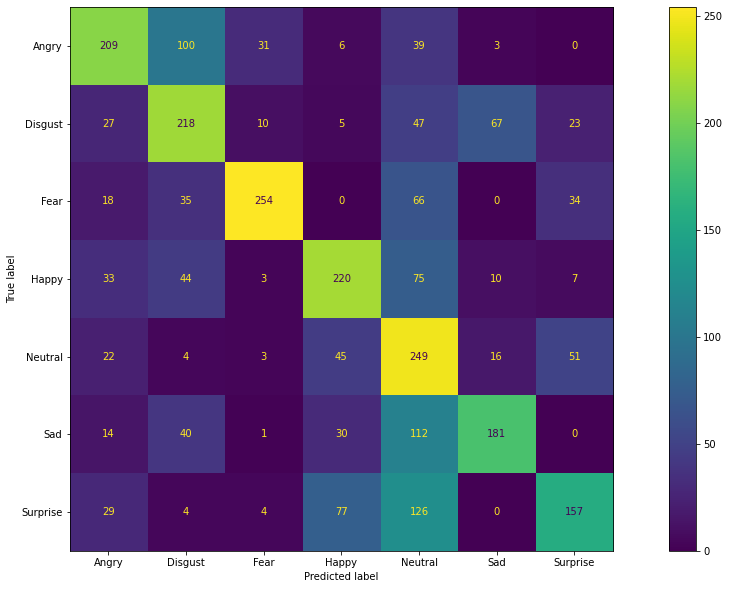

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
gbm_cm = ConfusionMatrixDisplay.from_predictions(y_test, gbm_model.predict(X_test), ax=ax)

In [12]:
gbm_cross_val_scores = cross_val(gbm_model)
print(gbm_cross_val_scores)
print("%0.2f mean accuracy with a standard deviation of %0.2f" % (gbm_cross_val_scores.mean(), gbm_cross_val_scores.std()))

[0.46938776 0.56869653 0.68295218 0.48693587 0.528403   0.48454084
 0.63113604 0.42463617 0.38941399 0.55035129]
0.52 mean accuracy with a standard deviation of 0.09


## Final model + export

In [13]:
lgb_final_model = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, num_leaves=best_num)
lgb_final_model.fit(X.drop("Subject number", axis=1),y["Expression"])

LGBMClassifier(learning_rate=0.11421052631578947, n_estimators=200,
               num_leaves=64)

In [14]:
pickle.dump(lgb_final_model, open("Exported_models/lgbm_model.sav", 'wb'))